In [1]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pprint

date_sentiments = {}
# html = urlopen("http://www.sundaytimes.lk/business")
#     bsObj = BeautifulSoup(html, features="html.parser")
#     posts = bsObj.findAll("div", {"class": "col-md-7"})
#     # print(posts)
#     for post in posts:
#         time.sleep(1)
#         url = post.a['href']
#         date = post.p.span.text
#         print(date,url)

for i in range(1,2):
    html = urlopen("http://www.sundaytimes.lk/search/John%20keells/"+str(i))
    bsObj = BeautifulSoup(html, features="html.parser")
    posts = bsObj.findAll("div", {"class": "col-md-7"})
    # print(posts)
    for post in posts:
        time.sleep(1)
        url = post.a['href']
        date = post.p.span.text
        date = date[1:-3]
        date = date.replace(',', '')
        date = datetime.strptime(date, "%B %d %Y %H:%M").strftime("%d/%m/%Y");
#         print(newDate)
#         print(date,url)
        try:
            link_page = urlopen(url).read()
        except:
            url = url[:-2]
            link_page = urlopen(url).read()
        link_soup = BeautifulSoup(link_page,"html5lib")
        sentences = link_soup.findAll("p")
        
#         print(sentences)
        
        passage = ""
        for sentence in sentences:
            if('class' in sentence.attrs):
                unwanted = sentence.text
            else:
                passage += sentence.text 
        sentiment = sia.polarity_scores(passage)['compound']
        date_sentiments.setdefault(date, []).append(sentiment)
#         print(date_sentiments)

date_sentiment = {}

for k,v in date_sentiments.items():
    date_sentiment[datetime.strptime(k, '%d/%m/%Y').date() + timedelta(days=1)] = round(sum(v)/float(len(v)),3)

earliest_date = min(date_sentiment.keys())
print(earliest_date)
# print(date_sentiment)

2018-10-29


Starting Portfolio Value: 100000.00
2018-11-16, Close, 210.23
None
2018-11-19, Close, 204.45
0.961
2018-11-20, Close, 200.99
0.961
2018-11-21, Close, 203.47
0.961
2018-11-23, Close, 203.35
0.961
2018-11-26, Close, 207.31
0.996
2018-11-27, Close, 206.02
0.996
2018-11-28, Close, 212.07
0.743
2018-11-29, Close, 212.08
0.743
2018-11-30, Close, 213.28
0.743
2018-12-03, Close, 216.73
0.743
2018-12-04, Close, 209.01
0.743
2018-12-06, Close, 208.53
0.743
2018-12-07, Close, 202.42
0.743
2018-12-10, Close, 203.22
0.743
2018-12-11, Close, 203.29
0.743
2018-12-12, Close, 205.42
0.813
2018-12-13, Close, 203.03
0.813
2018-12-14, Close, 200.07
0.813
2018-12-17, Close, 194.71
0.813
2018-12-18, Close, 195.58
0.813
2018-12-19, Close, 192.22
0.813
2018-12-20, Close, 188.07
0.813
2018-12-21, Close, 183.93
0.813
2018-12-24, Close, 180.79
0.813
2018-12-26, Close, 190.12
0.813
2018-12-27, Close, 191.48
0.813
2018-12-28, Close, 191.99
0.813
2018-12-31, Close, 194.19
0.813
2019-01-02, Close, 192.59
0.765
2019-

<IPython.core.display.Javascript object>


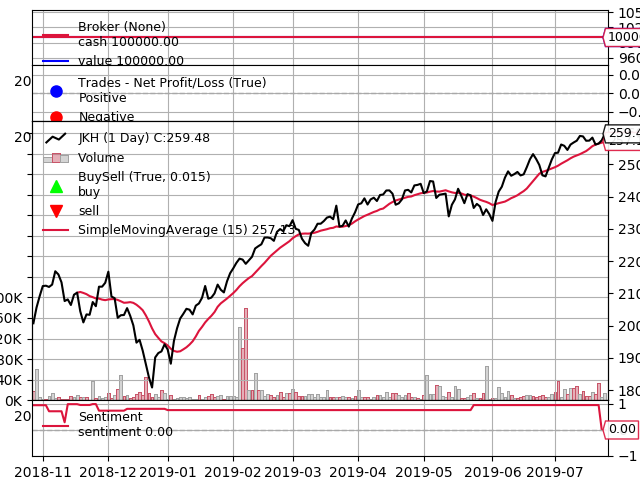

In [2]:
from __future__ import (absolute_import, division, print_function,
                            unicode_literals)

# %matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')

import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
import sys

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        print(self.sentiment)
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)
        

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname = 'JKH',
        fromdate = earliest_date,
        todate = datetime.datetime(2019,7,25),
        reverse = False
    )
    
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0.001)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()